In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np

import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt

2023-06-07 21:36:29.301579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#!XLA_PYTHON_CLIENT_MEM_FRACTION=.60

In [3]:
key = jax.random.PRNGKey(9)

In [4]:
n_params = 6

In [5]:
# fishnets functions

from typing import Sequence, Any
Array = Any

import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)


def construct_fisher_matrix_single(outputs):
    Q = tfp.math.fill_triangular(outputs)
    middle = jnp.diag(jnp.triu(Q) - nn.softplus(jnp.triu(Q)))
    padding = jnp.zeros(Q.shape)

    L = Q - fill_diagonal(padding, middle)

    return jnp.einsum('...ij,...jk->...ik', L, jnp.transpose(L, (1, 0))) + jnp.eye(n_params)



# custom activation function
@jax.jit
def almost_leaky(x: Array) -> Array:
  r"""Almost Leaky rectified linear unit activation function.
  Computes the element-wise function:
  .. math::
    \mathrm{almost\_leaky}(x) = \begin{cases}
      x, & x \leq -1\\
      - |x|^3/3, & -1 \leq x < 1\\
      3x & x > 1
    \end{cases}
  Args:
    x : input array
  """
  return jnp.where(x < -1, x, jnp.where((x < 1), ((-(jnp.abs(x)**3) / 3) + x*(x+2) + (1/3)), 3*x))




class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.softplus(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


class row_MLP(nn.Module):
    features: Sequence[int]
    n_params: int=6
    
    def setup(self):
        # self.eta0 = MLP(self.features)
        # self.eta1 = MLP(self.features)
        # self.eta2 = MLP(self.features)
        # self.eta3 = MLP(self.features)
        # self.eta4 = MLP(self.features)
        # self.eta5 = MLP(self.features)
        
        self.net = MLP(self.features)
        self.net2 = MLP(self.features)
        self.net3 = MLP(self.features)
        
    def __call__(self, x, masks):
        
        x1 = x
        x = self.net(x)
        x += x1
        x1 = self.net2(x)
        x += x1
        x = self.net3(x)
                
        return x
    
#     jnp.concatenate([self.eta0(x), self.eta1(x), 
#                                 self.eta2(x), self.eta3(x), 
#                                 self.eta4(x), self.eta5(x)], -1)



In [6]:
# load fishers
outdir = "/data80/makinen/degenerate_fishnets/saturation_test/"


mle_pred = jnp.load(outdir + "mle_pred_ndata_9500.npy")
F_fishnets = jnp.load(outdir + "F_pred_ndata_9500.npy") 

data = np.load('camb_TT_secret_params.npy')

# ADD 0.1 TO THETA SO THAT WE DON'T BLOW UP IN LOGSPACE
theta_ = jnp.array(data[:, :6]) + 0.1
data = jnp.arcsinh(data)[:, 6:][:, ::4] # take every fourth bin (for now)

# isolate some test data
num_test = 1000

# scale the fisher for network
scaling = np.max(np.abs(F_fishnets))

#F_fishnets /= scaling

theta_true = jnp.array(theta_[:])[:-num_test]
F_fishnets = F_fishnets[:-num_test]

Ftest = F_fishnets[-num_test:]
theta_test = theta_true[-num_test:]

theta_true.shape, F_fishnets.shape, Ftest.shape, theta_test.shape

((9000, 6), (9000, 6, 6), (1000, 6, 6), (1000, 6))

In [6]:
pwd

'/home/makinen/repositories/fishnets_for_degenerates/testing_saturation'

In [7]:
np.save("F_theta_test_01", Ftest)
np.save("theta_test_01", theta_test)

In [8]:
batch_size = 300

F_fishnets = F_fishnets.reshape(-1, batch_size, 6, 6)
theta_true = theta_true.reshape(-1, batch_size, 6)

In [9]:
# find which parameters depend the most on other parameters

Fave = np.mean(F_fishnets.reshape(-1, 6, 6), 0)

Fave /= Fave.max()

# define some threshold in terms of the maximum of the average fisher for which to compute degeneracies
threshold = 0.3


# do a dumb for loop
parameters = np.array(["A", "B", "C", "D", "E", "F"])
scores = []
row_masks = []

for row in range(6):
    # off digonal score
    score = np.sum(np.abs(Fave[row, :]))
    print("off diag sum for row %d :"%(row), score)
    
    off_diags = jnp.arange(6)[jnp.abs(Fave[row, :]) > threshold]
    
    mask = np.abs(Fave[row, :]) > threshold
    mask[row] = True
    row_masks.append(mask) 
    
    off_diags = off_diags[off_diags != row]
    
    print("params that most affect parameter %s:"%(parameters[row]), parameters[np.array(off_diags)])
    scores.append(score)

score_ordering = np.argsort(scores)[::-1]

print(parameters[score_ordering], score_ordering)

# convert to jax
score_ordering = jnp.array(score_ordering)
row_masks = jnp.array(row_masks)
scores = jnp.array(scores)

off diag sum for row 0 : 0.8201748
params that most affect parameter A: ['C']
off diag sum for row 1 : 1.6628314
params that most affect parameter B: ['C']
off diag sum for row 2 : 2.4112084
params that most affect parameter C: ['A' 'B' 'E']
off diag sum for row 3 : 0.17288312
params that most affect parameter D: []
off diag sum for row 4 : 1.3420266
params that most affect parameter E: ['C']
off diag sum for row 5 : 0.25582516
params that most affect parameter F: []
['C' 'B' 'E' 'A' 'F' 'D'] [2 1 4 0 5 3]


In [10]:
row_masks[5]

Array([False, False, False, False, False,  True], dtype=bool)

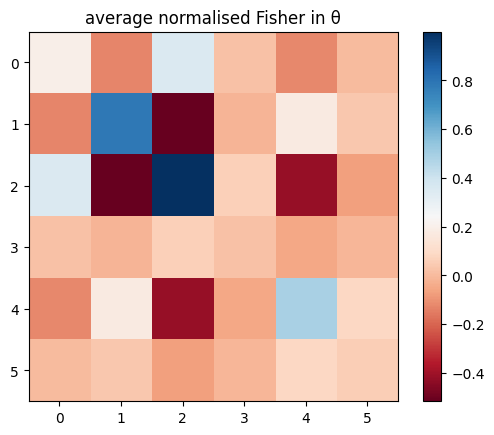

In [11]:
plt.imshow(Fave, cmap='RdBu')
plt.title("average normalised Fisher in θ")
plt.colorbar()

In [12]:
key = jax.random.PRNGKey(0)

n_outputs = int(n_params + int(n_params * (n_params + 1)) // 2)

theta_fid = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

hidden_size = 512

# forward and reverse models
model = row_MLP([n_params, hidden_size,hidden_size,hidden_size, n_params])

#hidden_size = 50

# forward and reverse models
#model = row_MLP([n_params,hidden_size,hidden_size,hidden_size, 1])

key1,key2 = jax.random.split(key)

w = model.init(key1, jnp.ones((n_params,)), row_masks)

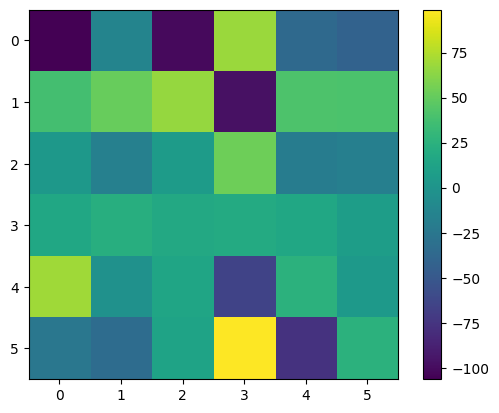

In [13]:
mymodel = lambda x: model.apply(w, x, row_masks)

# focus on the thetas that most affect the current variable
# set the non-important thetas to zero        
etas = mymodel(theta_[0])

plt.imshow(jnp.linalg.pinv(jax.jacobian(mymodel)(theta_[0])))
plt.colorbar()# take first element

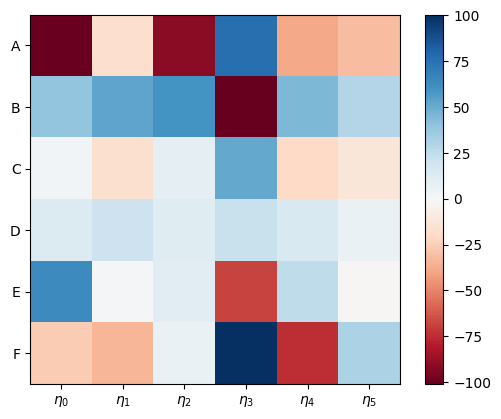

In [14]:
def get_F_eta(w, F_theta, theta):
    
    def fn(F, t):
    
        mymodel = lambda d: model.apply(w, d, row_masks)
        
        J_eta = jax.jacrev(mymodel)(t)
        
        J_eta = jnp.linalg.pinv(J_eta, hermitian=False)
        
        #Jeta_tinv = jnp.linalg.pinv(J_eta.T, hermitian=True)
                
        #Q = J_eta @ Jeta_tinv @ F_theta
        
        return J_eta.T @ F @ J_eta, J_eta
    
    return jax.vmap(fn)(F_theta, theta)
    
F_eta_i, J_eta_i = get_F_eta(w, F_fishnets.reshape(-1, 6, 6), theta_true.reshape(-1, 6))

plt.imshow(J_eta_i.mean(0), cmap="RdBu")
plt.yticks(ticks=np.arange(6),labels=["A","B","C","D","E","F"])
# get eta labels
eta_ticklabels = [r"$\eta_%d$"%(i) for i in range(6)]
plt.xticks(ticks=np.arange(6),labels=eta_ticklabels)

plt.colorbar()

In [15]:
from functools import partial
# learn η(θ; w) function where η is a neural network

@jax.jit
def norm(A):
    return jnp.sqrt(jnp.einsum('ij,ij->', A, A))

@jax.jit
def pnorm(A, p=3):
    return jnp.linalg.norm(A, ord=p)

def get_α(λ=100., ϵ=0.1):
    return - jnp.log(ϵ * (λ - 1.) + ϵ ** 2. / (1 + ϵ)) / ϵ

@jax.jit
def L1norm(A):
    return jnp.linalg.norm(A, ord=1)

@jax.jit # 0.01
def l1_reg(x, alpha=0.01):
    return alpha * (jnp.abs(x)).mean()

    
@partial(jax.jit, static_argnums=())
def info_loss(w, theta_batched, F_batched):
    λ=10. 
    ϵ=0.00001
    α = get_α(λ, ϵ)
    def fn(theta, F):
        #outputs = model.apply(w, theta)
        
        # forward model is model_eta
        mymodel = lambda x: model.apply(w, x, row_masks)
        
        # focus on the thetas that most affect the current variable
        # set the non-important thetas to zero        
        etas = mymodel(theta)
        
        J_eta = jax.jacobian(mymodel)(theta) # take first element
                
        Jeta_inv = jnp.linalg.pinv(J_eta, hermitian=False)        
        Q = Jeta_inv.T @ F @ Jeta_inv
        
        # reverse model is model_theta
        #_,thetas_pred = mymodel(jnp.ones(theta.shape), etas)
        
        # loss is a combination of both mappings
        invQ = jnp.linalg.inv(Q)
        
        
        loss = norm((Q - jnp.eye(n_params))) + norm((invQ - jnp.eye(n_params)))
        r =  λ * loss / (loss + jnp.exp(-1.0*α*loss))
        loss *= r
        
        # add L1 regularization for jacobian
        loss += l1_reg(J_eta.reshape(-1))
        
        #loss += jnp.log(jnp.abs(jnp.linalg.det(Q - jnp.eye(n_params)) + 1.0))

        return loss, jnp.linalg.det(Q)
    
    loss,Q = jax.vmap(fn)(theta_batched, F_batched)

    return jnp.mean(loss), jnp.mean(Q)

In [16]:
model_key = jax.random.PRNGKey(99)

In [17]:
from tqdm import tqdm
import optax
tx = optax.adam(learning_rate=5e-5)
opt_state = tx.init(w)
loss_grad_fn = jax.value_and_grad(info_loss, has_aux=True)


batch_size = 300
epochs = 500

w = model.init(model_key, jnp.ones((n_params,)), row_masks)

losses = jnp.zeros(epochs)

In [18]:
def body_fun(i, inputs):
    w,loss_val, opt_state, detFeta = inputs
    theta_samples = theta_true[i]
    F_samples = F_fishnets[i]

    (loss_val, detFeta), grads = loss_grad_fn(w, theta_samples, F_samples)
    updates, opt_state = tx.update(grads, opt_state)
    w = optax.apply_updates(w, updates)
    
    return w, loss_val, opt_state, detFeta

In [19]:
tx = optax.adam(learning_rate=1e-4)
opt_state = tx.init(w)

In [20]:
theta_true.shape

(30, 300, 6)

In [21]:
info_loss(w, theta_true[0], F_fishnets[0])

2023-06-07 21:38:18.494670: W external/xla/xla/service/gpu/ir_emitter_triton.cc:761] Shared memory size limit exceeded.


(Array(1.3752541e+11, dtype=float32), Array(inf, dtype=float32))

In [227]:
tshape = theta_true.shape,
fshape = F_fishnets.shape

tshape, fshape

(((30, 300, 6),), (30, 300, 6, 6))

In [23]:
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [229]:
batch_size

300

In [ ]:
from tqdm import tqdm
#from tqdm.notebook import trange
epochs = 10000



key = jax.random.PRNGKey(999)

losses = jnp.zeros(epochs)
detFetas = jnp.zeros(epochs)

best_loss = jnp.inf
modelname = "/data80/makinen/degenerate_fishnets/flatten_net_full_k_w"

loss_val = 0.
detFeta = 0.

lower = 0
upper = 3000 // batch_size

pbar = tqdm(range(epochs), leave=True, position=0)

for j in pbar:
  key,rng = jax.random.split(key)
  
  # shuffle data every epoch
  randidx = jax.random.shuffle(key, jnp.arange(theta_true.reshape(-1, 6).shape[0]))
  F_fishnets = F_fishnets.reshape(-1, 6, 6)[randidx].reshape(*fshape)
  theta_true = theta_true.reshape(-1, 6)[randidx].reshape(*tshape)
  
  inits = (w, loss_val, opt_state, detFeta)

  w, loss_val, opt_state, detFeta = jax.lax.fori_loop(lower, upper, body_fun, inits)


  losses = losses.at[j].set(loss_val)
  detFetas = detFetas.at[j].set(detFeta)
  #val_losses.append(val_loss)
  pbar.set_description('epoch %d loss: %.5f, detFeta: %.5f'%(j, loss_val, detFeta))

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.1, 100.0)

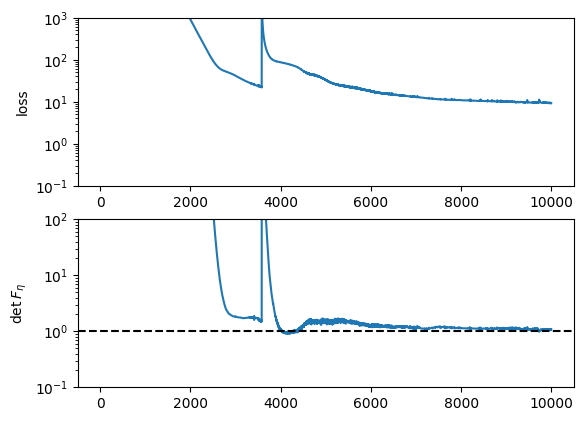

In [231]:
plt.subplot(211)
plt.plot(losses)
plt.ylabel("loss")

plt.yscale("log")
plt.ylim(0.1, 1000)

plt.subplot(212)
plt.plot(detFetas)
plt.axhline(1.0, ls='--', color='k')
plt.ylabel(r"$\det F_\eta$")
plt.yscale("log")
plt.ylim(0.1, 1e2)

In [232]:
def load_eta_component(index):
    list_of_files = glob.glob('eta%d/*.pkl'%(index))
    latest_file = max(list_of_files, key=os.path.getctime)
    return PySRRegressor.from_file(latest_file)

In [233]:
θs = theta_true.reshape(-1, 6)

In [234]:
# get some predictions over θ

ηs = model.apply(w, θs, row_masks)



# plot $F_\eta$

get from $F_\eta = J^T F_\theta J$

In [27]:
def get_F_eta(w, F_theta, theta):
    
    def fn(F, t):
    
        mymodel = lambda d: model.apply(w, d, row_masks)
        
        J_eta_ = jax.jacrev(mymodel)(t)
        
        Jeta_inv = jnp.linalg.pinv(J_eta_, hermitian=False)
        
        #Jeta_tinv = jnp.linalg.pinv(J_eta.T, hermitian=True)
                
        #Q = J_eta @ Jeta_tinv @ F_theta
        
        return Jeta_inv.T @ F @ Jeta_inv, Jeta_inv, J_eta_
    
    return jax.vmap(fn)(F_theta, theta)
    
F_eta, Jeta_inv, J_eta = get_F_eta(w, F_fishnets.reshape(-1, 6, 6), theta_true.reshape(-1, 6))

Text(0.5, 1.0, 'average learned jacobian')

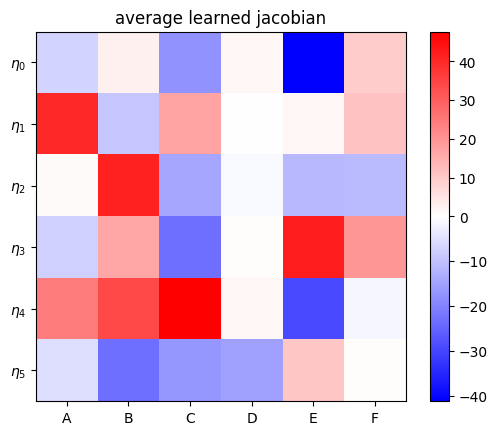

In [28]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm( vcenter=0.)

plt.imshow(J_eta.mean(0), cmap="bwr", norm=divnorm)
plt.xticks(ticks=np.arange(6),labels=["A","B","C","D","E","F"])
eta_ticklabels = [r"$\eta_%d$"%(i) for i in range(6)]
plt.yticks(ticks=np.arange(6),labels=eta_ticklabels)
plt.colorbar()
plt.title("average learned jacobian")

Text(0.5, 1.0, 'new network variance of learned jacobian')

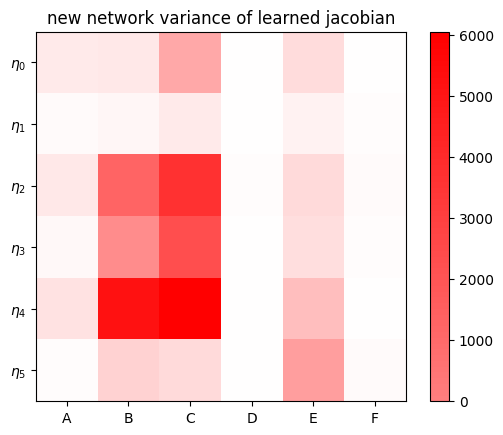

In [29]:
divnorm=colors.TwoSlopeNorm( vcenter=0.0)
plt.imshow((J_eta.var(0)), cmap="bwr", norm=divnorm)
plt.xticks(ticks=np.arange(6),labels=["A","B","C","D","E","F"])
eta_ticklabels = [r"$\eta_%d$"%(i) for i in range(6)]
plt.yticks(ticks=np.arange(6),labels=eta_ticklabels)
plt.colorbar()
plt.title("new network variance of learned jacobian")

In [32]:
# ORDERING:
#           old param 1, old param 2
# new param
# new param

In [105]:
def f(θ):
    return jnp.array([jnp.sqrt(θ[0] / 0.3)*θ[1], θ[1]])

jax.jacrev(f)(jnp.array([0.001, 1.0]))

Array([[28.867512  ,  0.05773503],
       [ 0.        ,  1.        ]], dtype=float32)

In [93]:
pwd

'/home/makinen/repositories/fishnets_for_degenerates/testing_saturation'

In [258]:
np.save("01/theta_true_for_sr", theta_true.reshape(-1, 6))
np.save("01/F_theta_for_sr", F_fishnets.reshape(-1, 6, 6))

In [95]:
outdir = "/data80/makinen/degenerate_fishnets/sr/eta_saturated/"

np.save(outdir + "theta_true_for_sr", theta_true.reshape(-1, 6))
np.save(outdir + "F_theta_for_sr", F_fishnets.reshape(-1, 6, 6))

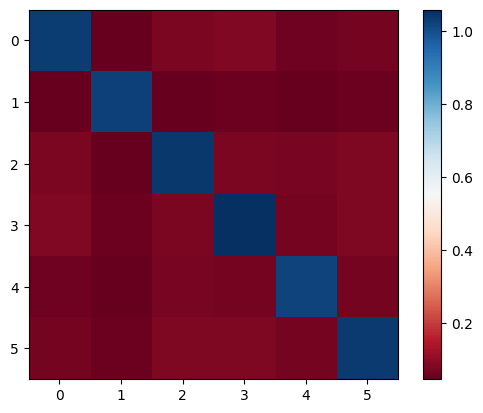

In [30]:
plt.imshow(np.mean(np.abs(F_eta), 0), cmap="RdBu")
plt.colorbar()

In [31]:
# get covariance of η(θ) mapping of prior p(θ)
plt.imshow(np.cov(ηs, rowvar=False) )#/ np.cov(θs, rowvar=False))
plt.colorbar()

NameError: name 'ηs' is not defined

In [32]:
F_eta_test, Jeta_inv_test, J_eta_test = get_F_eta(w, Ftest.reshape(-1, 6, 6), theta_test.reshape(-1, 6))

/data80/makinen/venvs/fastjax/lib/python3.9/site-packages/chainconsumer/chainconsumer.py:346: RuntimeWarning: covariance is not positive-semidefinite.
  chain = np.random.multivariate_normal(mean, covariance, size=1000000)


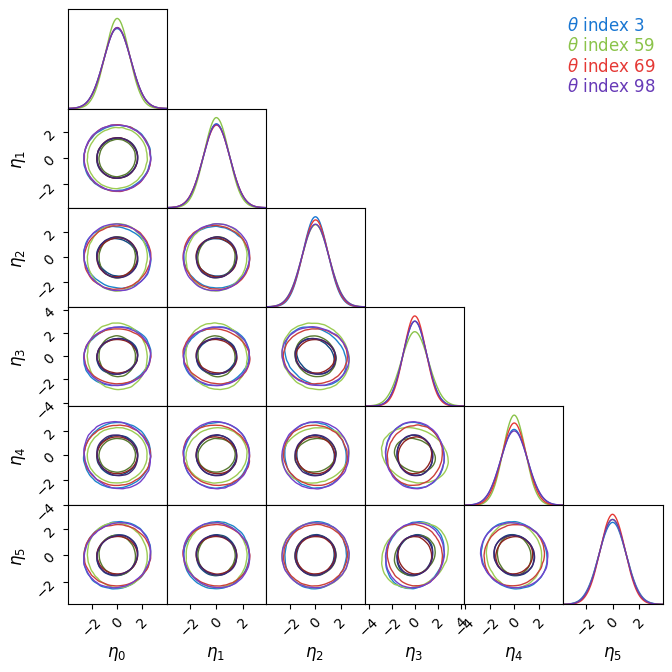

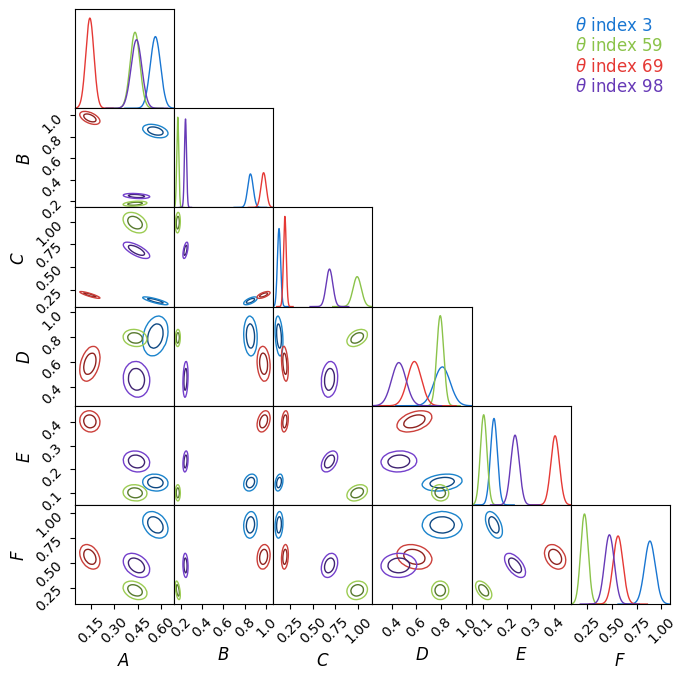

In [33]:
from chainconsumer import ChainConsumer
cs = ChainConsumer()

indx = [3,59,69,98] #np.random.randint(low=0, high=99, size=4)

# --- plot in eta ---

for i in indx:
    cs.add_covariance(np.zeros(6), np.linalg.inv(F_eta_test.reshape(-1, 6, 6)[i]), parameters=[r"$\eta_%d$"%(i) for i in range(6)],
                     name = r"$\theta$ index %d"%(i)) #, color=corner_colors[0])
        
cs.plotter.plot((7,7))

#plt.savefig("eta_flattened_jacobian_L1.png")
plt.show()

# --- plot in theta ---
cs = ChainConsumer()


for i in indx:
    cs.add_covariance(theta_test[i], np.linalg.inv(Ftest.reshape(-1, 6, 6)[i]), parameters=[r"$%s$"%(d) for d in "ABCDEF"], 
                     name = r"$\theta$ index %d"%(i)) #, color=corner_colors[0])
        
cs.plotter.plot((7,7))

#plt.savefig("theta_jacobian_L1.png")
plt.show()

## standardize for pysr

In [241]:
sr_dir = "/data80/makinen/degenerate_fishnets/sr/eta_01/"

In [34]:
import joblib

theta_for_sr = np.random.uniform(low=0.0, high=1.0, size=(10000, 6)) + 0.1
eta_for_sr = model.apply(w, theta_for_sr, row_masks)


# save unscaled coordinates
data_for_sr = jnp.concatenate([theta_for_sr, eta_for_sr], -1)
np.save(sr_dir + "unscaled_cmb_coords_for_sr_new", data_for_sr)


# standardize the etas
#scaler = MinMaxScaler()

#scaler.fit(eta_for_sr)
#eps = 1e-9

etamax = eta_for_sr.max(0)
etamin = eta_for_sr.min(0)

eta_transformed = (eta_for_sr - etamin) / (etamax - etamin)
#eta_transformed += eps

data_for_sr = jnp.concatenate([theta_for_sr, eta_transformed], -1)

np.save(sr_dir + "scaled_cmb_coords_for_sr_new", data_for_sr)

# save scaler attributes
np.save(sr_dir + "minmax_new", (etamin,etamax))

In [243]:
save_obj(w, sr_dir + "flattening_network_w")

In [244]:
theta_for_sr.min()

0.1000108545698051

In [246]:
J_eta.shape

(9000, 6, 6)

In [252]:
appl = lambda d: model.apply(w, d, masks=jnp.ones(6))
derv_for_sr = jax.vmap(jax.jacrev(appl))(theta_for_sr[:])

In [253]:
derv_for_sr.shape

(10000, 6, 6)

In [255]:
np.save(sr_dir + "derv_for_sr_01", derv_for_sr)

In [25]:
sr_dir = "/data80/makinen/degenerate_fishnets/sr/eta_01/"
w = load_obj(sr_dir + "flattening_network_w.pkl")